In [2]:
import numpy as np
import scipy as scy
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import os
from os.path import dirname

from astropy.nddata import CCDData
from astropy.visualization import hist
import ccdproc as ccdp
from astropy.stats import mad_std
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
import photutils
from photutils import IterativelySubtractedPSFPhotometry, aperture_photometry
#from convenience_functions import show_image

from ccdproc import CCDData, trim_image, subtract_bias, subtract_dark, flat_correct, Combiner

In [7]:
flat_g_1 =  CCDData.read('flat_g/flat_g.0048.fits', unit='adu')
flat_g_2 =  CCDData.read('flat_g/flat_g.0049.fits', unit='adu')
flat_g_3 =  CCDData.read('flat_g/flat_g.0050.fits', unit='adu')
flat_g_4 =  CCDData.read('flat_g/flat_g.0051.fits', unit='adu')
flat_g_5 =  CCDData.read('flat_g/flat_g.0052.fits', unit='adu')
flat_g_6 =  CCDData.read('flat_g/flat_g.0053.fits', unit='adu')
flat_g_7 =  CCDData.read('flat_g/flat_g.0054.fits', unit='adu')
flat_g_8 =  CCDData.read('flat_g/flat_g.0055.fits', unit='adu')
flat_g_9 =  CCDData.read('flat_g/flat_g.0056.fits', unit='adu')
flat_g_10 =  CCDData.read('flat_g/flat_g.0057.fits', unit='adu')
flat_g_11 =  CCDData.read('flat_g/flat_g.0058.fits', unit='adu')
flat_g_12 =  CCDData.read('flat_g/flat_g.0059.fits', unit='adu')
flat_g_13 =  CCDData.read('flat_g/flat_g.0060.fits', unit='adu')
flat_g_14 =  CCDData.read('flat_g/flat_g.0061.fits', unit='adu')
flat_g_15 =  CCDData.read('flat_g/flat_g.0062.fits', unit='adu')

g_flats = [flat_g_1, flat_g_2, flat_g_3, flat_g_4, flat_g_5, flat_g_6, flat_g_7, flat_g_8,
            flat_g_9, flat_g_10, flat_g_11, flat_g_12, flat_g_13, flat_g_14, flat_g_15]


flat_i_1 =  CCDData.read('flat_i/flat_i.0068.fits', unit='adu')
flat_i_2 =  CCDData.read('flat_i/flat_i.0069.fits', unit='adu')
flat_i_3 =  CCDData.read('flat_i/flat_i.0070.fits', unit='adu')
flat_i_4 =  CCDData.read('flat_i/flat_i.0071.fits', unit='adu')
flat_i_5 =  CCDData.read('flat_i/flat_i.0072.fits', unit='adu')

i_flats = [flat_i_1, flat_i_2, flat_i_3, flat_i_4, flat_i_5]


flat_r_1 =  CCDData.read('flat_r/flat_r.0063.fits', unit='adu')
flat_r_2 =  CCDData.read('flat_r/flat_r.0064.fits', unit='adu')
flat_r_3 =  CCDData.read('flat_r/flat_r.0065.fits', unit='adu')
flat_r_4 =  CCDData.read('flat_r/flat_r.0066.fits', unit='adu')
flat_r_5 =  CCDData.read('flat_r/flat_r.0067.fits', unit='adu')

r_flats = [flat_r_1, flat_r_2, flat_r_3, flat_r_4, flat_r_5]

bias_1 = CCDData.read('biases/Bias.0010.fits', unit = 'adu')
bias_2 = CCDData.read('biases/Bias.0011.fits', unit = 'adu')
bias_3 = CCDData.read('biases/Bias.0012.fits', unit = 'adu')
bias_4 = CCDData.read('biases/Bias.0013.fits', unit = 'adu')
bias_5 = CCDData.read('biases/Bias.0014.fits', unit = 'adu')
bias_6 = CCDData.read('biases/Bias.0015.fits', unit = 'adu')
bias_7 = CCDData.read('biases/Bias.0016.fits', unit = 'adu')
bias_8 = CCDData.read('biases/Bias.0017.fits', unit = 'adu')
bias_9 = CCDData.read('biases/Bias.0018.fits', unit = 'adu')
bias_10 = CCDData.read('biases/Bias.0019.fits', unit = 'adu')

bias1 = overscan_be_gone(bias_1)
bias2 = overscan_be_gone(bias_2)
bias3 = overscan_be_gone(bias_3)
bias4 = overscan_be_gone(bias_4)
bias5 = overscan_be_gone(bias_5)
bias6 = overscan_be_gone(bias_6)
bias7 = overscan_be_gone(bias_7)
bias8 = overscan_be_gone(bias_8)
bias9 = overscan_be_gone(bias_9)
bias10 = overscan_be_gone(bias_10)

biases_no_overscan = [bias_1, bias_2, bias_3, bias_4, bias_5, bias_6, bias_7, bias_8, bias_9, bias_10]

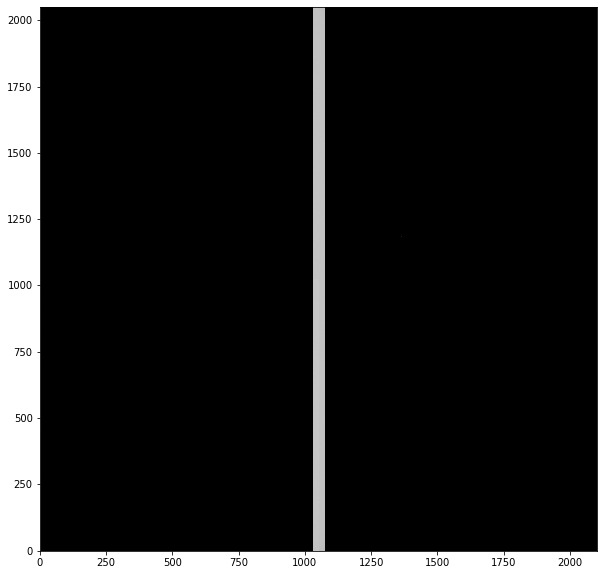

In [8]:
fig, ax = plt.subplots(figsize = (10,10))

ax.imshow(flat_g_1, cmap = 'Greys', origin = 'lower', vmin = 50, vmax = 1000);

In [9]:
def overscan_be_gone(raw_image):
    csec11 = raw_image.header['DSEC11']
    csec12 = raw_image.header['DSEC12']
    csec21 = raw_image.header['DSEC21']
    csec22 = raw_image.header['DSEC22']
    sec1 = ccdp.trim_image(raw_image, csec11)
    sec2 = ccdp.trim_image(raw_image, csec12)
    sec3 = ccdp.trim_image(raw_image, csec21)
    sec4 = ccdp.trim_image(raw_image, csec22)
    n = len(sec4.data)
    img = np.ndarray((2*n,2*n))
    img[:n,:n] = sec1.data
    img[:n,n:] = sec3.data
    img[n:,:n] = sec2.data
    img[n:,n:] = sec4.data 
    raw_image.header['Overscan']='Overscan trimmed'
    image = CCDData(img,unit='adu',header=raw_image.header)
    return(image)

In [10]:
trim_flat_g_1 = overscan_be_gone(flat_g_1)
trim_flat_g_2 = overscan_be_gone(flat_g_2)
trim_flat_g_3 = overscan_be_gone(flat_g_3)
trim_flat_g_4 = overscan_be_gone(flat_g_4)
trim_flat_g_5 = overscan_be_gone(flat_g_5)
trim_flat_g_6 = overscan_be_gone(flat_g_6)
trim_flat_g_7 = overscan_be_gone(flat_g_7)
trim_flat_g_8 = overscan_be_gone(flat_g_8)
trim_flat_g_9 = overscan_be_gone(flat_g_9)
trim_flat_g_10 = overscan_be_gone(flat_g_10)
trim_flat_g_11 = overscan_be_gone(flat_g_11)
trim_flat_g_12 = overscan_be_gone(flat_g_12)
trim_flat_g_13 = overscan_be_gone(flat_g_13)
trim_flat_g_14 = overscan_be_gone(flat_g_14)
trim_flat_g_15 = overscan_be_gone(flat_g_15)

trim_g_flats = [trim_flat_g_1, trim_flat_g_2, trim_flat_g_3, trim_flat_g_4, trim_flat_g_5, trim_flat_g_6, trim_flat_g_7,
                trim_flat_g_8, trim_flat_g_9, trim_flat_g_10, trim_flat_g_11, trim_flat_g_1, trim_flat_g_12, trim_flat_g_13, trim_flat_g_14, trim_flat_g_15]

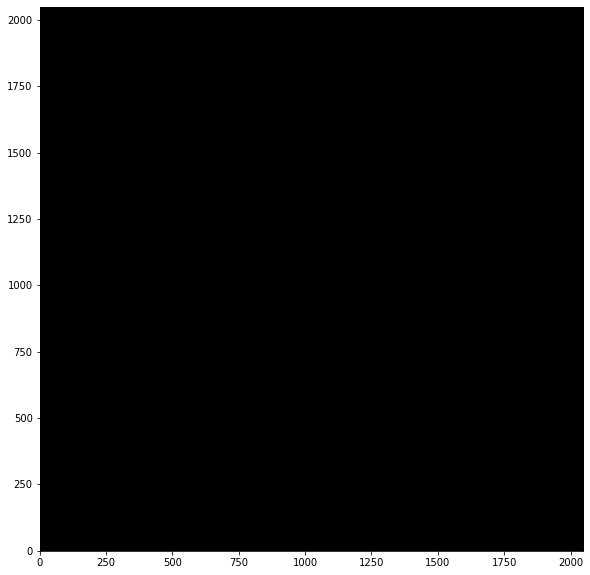

In [11]:
fig, ax = plt.subplots(figsize = (10,10))

ax.imshow(trim_flat_g_1, cmap = 'Greys', origin = 'lower', vmin = 50, vmax = 1000);

In [12]:
trim_flat_i_1 = overscan_be_gone(flat_i_1)
trim_flat_i_2 = overscan_be_gone(flat_i_2)
trim_flat_i_3 = overscan_be_gone(flat_i_3)
trim_flat_i_4 = overscan_be_gone(flat_i_4)
trim_flat_i_5 = overscan_be_gone(flat_i_5)

trim_flat_r_1 = overscan_be_gone(flat_r_1)
trim_flat_r_2 = overscan_be_gone(flat_r_2)
trim_flat_r_3 = overscan_be_gone(flat_r_3)
trim_flat_r_4 = overscan_be_gone(flat_r_4)
trim_flat_r_5 = overscan_be_gone(flat_r_5)

trim_flat_r_1.shape

(2048, 2048)

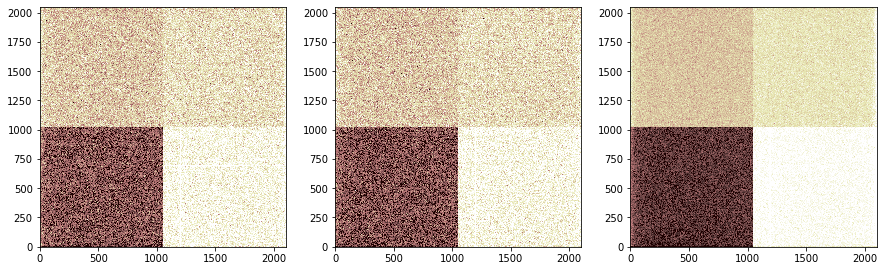

In [13]:
more_biases = Combiner(biases_no_overscan)

master_bias = more_biases.median_combine()

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(bias_1,vmin = np.percentile(bias_1, 5), vmax=np.percentile(bias_1, 90), origin='lower', interpolation='nearest',cmap='pink') 
plt.subplot(1,3,2)
plt.imshow(bias_2,vmin = np.percentile(bias_2, 5), vmax=np.percentile(bias_2, 90),
origin='lower', interpolation='nearest',cmap='pink') 
plt.subplot(1,3,3)
plt.imshow(master_bias,vmin = np.percentile(master_bias, 5), vmax=np.percentile(master_bias, 90),
origin='lower', interpolation='nearest',cmap='pink') ;

In [14]:
master_bias.header = bias_1.header
master_bias.header['Combined'] = 'Combined with biases 1 through 10'

real_master_bias = overscan_be_gone(master_bias)



print(real_master_bias.shape, 'vs', trim_flat_g_1.shape)

(2048, 2048) vs (2048, 2048)


In [15]:
#master_bias.write('REAL_master_bias.fits')

In [16]:
g_nb1 = ccdp.subtract_bias(trim_flat_g_1, real_master_bias)
g_nb2 = ccdp.subtract_bias(trim_flat_g_2, real_master_bias)
g_nb3 = ccdp.subtract_bias(trim_flat_g_3, real_master_bias)
g_nb4 = ccdp.subtract_bias(trim_flat_g_4, real_master_bias)
g_nb5 = ccdp.subtract_bias(trim_flat_g_5, real_master_bias)
g_nb6 = ccdp.subtract_bias(trim_flat_g_6, real_master_bias)
g_nb7 = ccdp.subtract_bias(trim_flat_g_7, real_master_bias)
g_nb8 = ccdp.subtract_bias(trim_flat_g_8, real_master_bias)
g_nb9 = ccdp.subtract_bias(trim_flat_g_9, real_master_bias)
g_nb10 = ccdp.subtract_bias(trim_flat_g_10, real_master_bias)
g_nb11 = ccdp.subtract_bias(trim_flat_g_11, real_master_bias)
g_nb12 = ccdp.subtract_bias(trim_flat_g_12, real_master_bias)
g_nb13 = ccdp.subtract_bias(trim_flat_g_13, real_master_bias)
g_nb14 = ccdp.subtract_bias(trim_flat_g_14, real_master_bias)
g_nb15 = ccdp.subtract_bias(trim_flat_g_15, real_master_bias)

gg = [g_nb1, g_nb2, g_nb3, g_nb4, g_nb5, g_nb6, g_nb7, g_nb8, g_nb9, g_nb10, g_nb11, g_nb12, g_nb13, g_nb14, g_nb15]

i_nb1 = ccdp.subtract_bias(trim_flat_i_1, real_master_bias)
i_nb2 = ccdp.subtract_bias(trim_flat_i_2, real_master_bias)
i_nb3 = ccdp.subtract_bias(trim_flat_i_3, real_master_bias)
i_nb4 = ccdp.subtract_bias(trim_flat_i_4, real_master_bias)
i_nb5 = ccdp.subtract_bias(trim_flat_i_5, real_master_bias)


ii = [i_nb1, i_nb2, i_nb3, i_nb4, i_nb5]

r_nb1 = ccdp.subtract_bias(trim_flat_r_1, real_master_bias)
r_nb2 = ccdp.subtract_bias(trim_flat_r_2, real_master_bias)
r_nb3 = ccdp.subtract_bias(trim_flat_r_3, real_master_bias)
r_nb4 = ccdp.subtract_bias(trim_flat_r_4, real_master_bias)
r_nb5 = ccdp.subtract_bias(trim_flat_r_5, real_master_bias)

rr = [r_nb1, r_nb2, r_nb3, r_nb4, r_nb5]

In [17]:
def inverse_median(a):
    return 1/np.median(a)

In [18]:
#combine and normalize g dome-flats
dome_combine_flat_g = ccdp.combine(gg, method = 'average', scale = inverse_median, format = 'fits')
dome_combine_flat_g.meta['combined'] = True
#dome_combine_flat_g.write('master_dome_flat_g.fits')

In [19]:
#combine and normalize i dome-flats
dome_combine_flat_i = ccdp.combine(ii, method = 'average', scale = inverse_median, format = 'fits')
dome_combine_flat_i.meta['combined'] = True
#dome_combine_flat_i.write('master_dome_flat_i.fits')

In [20]:
#combine and normalize r dome-flats
dome_combine_flat_r = ccdp.combine(rr, method = 'average', scale = inverse_median, format = 'fits')
dome_combine_flat_r.meta['combined'] = True
#dome_combine_flat_r.write('master_dome_flat_r.fits')

In [21]:
skyflat_g_1 =  CCDData.read('skyflats/g/SkyFlatg.0031.fits', unit='adu')
skyflat_g_2 =  CCDData.read('skyflats/g/SkyFlatg.0032.fits', unit='adu')
skyflat_g_3 =  CCDData.read('skyflats/g/SkyFlatg.0033.fits', unit='adu')
skyflat_g_4 =  CCDData.read('skyflats/g/SkyFlatg.0034.fits', unit='adu')
skyflat_g_5 =  CCDData.read('skyflats/g/SkyFlatg.0035.fits', unit='adu')

skyflat_i_1 =  CCDData.read('skyflats/i/SkyFlati.0041.fits', unit='adu')
skyflat_i_2 =  CCDData.read('skyflats/i/SkyFlati.0042.fits', unit='adu')
skyflat_i_3 =  CCDData.read('skyflats/i/SkyFlati.0043.fits', unit='adu')
skyflat_i_4 =  CCDData.read('skyflats/i/SkyFlati.0044.fits', unit='adu')
skyflat_i_5 =  CCDData.read('skyflats/i/SkyFlati.0045.fits', unit='adu')
skyflat_i_6 =  CCDData.read('skyflats/i/SkyFlati.0046.fits', unit='adu')

skyflat_r_1 =  CCDData.read('skyflats/r/SkyFlatr.0036.fits', unit='adu')
skyflat_r_2 =  CCDData.read('skyflats/r/SkyFlatr.0037.fits', unit='adu')
skyflat_r_3 =  CCDData.read('skyflats/r/SkyFlatr.0038.fits', unit='adu')
skyflat_r_4 =  CCDData.read('skyflats/r/SkyFlatr.0039.fits', unit='adu')
skyflat_r_5 =  CCDData.read('skyflats/r/SkyFlatr.0040.fits', unit='adu')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


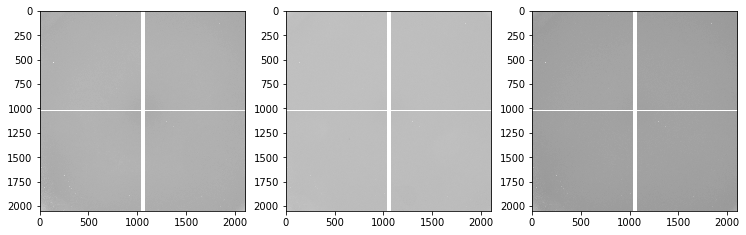

In [22]:
plt.figure(figsize=(12.5,10))
plt.subplot(1,3,1)
plt.imshow(skyflat_g_1, cmap = 'Greys')
plt.subplot(1,3,2)
plt.imshow(skyflat_i_1, cmap = 'Greys')
plt.subplot(1,3,3)
plt.imshow(skyflat_r_1, cmap = 'Greys');

In [23]:
s_g_1 = overscan_be_gone(skyflat_g_1)
s_g_2 = overscan_be_gone(skyflat_g_2)
s_g_3 = overscan_be_gone(skyflat_g_3)
s_g_4 = overscan_be_gone(skyflat_g_4)
s_g_5 = overscan_be_gone(skyflat_g_5)

s_i_1 = overscan_be_gone(skyflat_i_1)
s_i_2 = overscan_be_gone(skyflat_i_2)
s_i_3 = overscan_be_gone(skyflat_i_3)
s_i_4 = overscan_be_gone(skyflat_i_4)
s_i_5 = overscan_be_gone(skyflat_i_5)
s_i_6 = overscan_be_gone(skyflat_i_6)

s_r_1 = overscan_be_gone(skyflat_r_1)
s_r_2 = overscan_be_gone(skyflat_r_2)
s_r_3 = overscan_be_gone(skyflat_r_3)
s_r_4 = overscan_be_gone(skyflat_r_4)
s_r_5 = overscan_be_gone(skyflat_r_5) 

In [24]:
nb_s_g_1 = ccdp.subtract_bias(s_g_1, real_master_bias)
nb_s_g_2 = ccdp.subtract_bias(s_g_2, real_master_bias)
nb_s_g_3 = ccdp.subtract_bias(s_g_3, real_master_bias)
nb_s_g_4 = ccdp.subtract_bias(s_g_4, real_master_bias)
nb_s_g_5 = ccdp.subtract_bias(s_g_5, real_master_bias)

skyflats_g = [nb_s_g_1, nb_s_g_2, nb_s_g_3, nb_s_g_4, nb_s_g_5]

nb_s_i_1 = ccdp.subtract_bias(s_i_1, real_master_bias)
nb_s_i_2 = ccdp.subtract_bias(s_i_2, real_master_bias)
nb_s_i_3 = ccdp.subtract_bias(s_i_3, real_master_bias)
nb_s_i_4 = ccdp.subtract_bias(s_i_4, real_master_bias)
nb_s_i_5 = ccdp.subtract_bias(s_i_5, real_master_bias)
nb_s_i_6 = ccdp.subtract_bias(s_i_6, real_master_bias)

skyflats_i = [nb_s_i_1, nb_s_i_2, nb_s_i_3, nb_s_i_4, nb_s_i_5, nb_s_i_6]

nb_s_r_1 = ccdp.subtract_bias(s_r_1, real_master_bias)
nb_s_r_2 = ccdp.subtract_bias(s_r_2, real_master_bias)
nb_s_r_3 = ccdp.subtract_bias(s_r_3, real_master_bias)
nb_s_r_4 = ccdp.subtract_bias(s_r_4, real_master_bias)
nb_s_r_5 = ccdp.subtract_bias(s_r_5, real_master_bias)

skyflats_r = [nb_s_r_1, nb_s_r_2, nb_s_r_3, nb_s_r_4, nb_s_r_5]

In [25]:
#combine and normalize g sky-flats
combine_flat_g = ccdp.combine(skyflats_g, method = 'average', scale = inverse_median, format = 'fits')
combine_flat_g.meta['combined'] = True
#combine_flat_g.write('master_sky_flat_g.fits')

In [26]:
#combine and normalize i sky-flats
combine_flat_i = ccdp.combine(skyflats_i, method = 'average', scale = inverse_median, format = 'fits')
combine_flat_i.meta['combined'] = True
#combine_flat_i.write('master_sky_flat_i.fits')

In [27]:
#combine and normalize r sky-flats
combine_flat_r = ccdp.combine(skyflats_r, method = 'average', scale = inverse_median, format = 'fits')
combine_flat_r.meta['combined'] = True
#combine_flat_r.write('master_sky_flat_r.fits')

In [29]:
#Now we must correct our sky flats with our dome flats
#G FILTER
superflat_g = ccdp.flat_correct(combine_flat_g, dome_combine_flat_g)
superflat_g.meta['combined'] = True
#superflat_g.write('superflat_g.fits')

In [30]:
#Now we must correct our sky flats with our dome flats
#i FILTER
superflat_i = ccdp.flat_correct(combine_flat_i, dome_combine_flat_i)
superflat_i.meta['combined'] = True
#superflat_i.write('superflat_i.fits')

In [31]:
#Now we must correct our sky flats with our dome flats
#R FILTER
superflat_r = ccdp.flat_correct(combine_flat_r, dome_combine_flat_r)
superflat_r.meta['combined'] = True
#superflat_r.write('superflat_r.fits')

In [32]:
m56_g = CCDData.read('m56/M56_g_30.0089.fits', unit = 'adu')
m56_i = CCDData.read('m56/M56_i_30.0088.fits', unit = 'adu')
m56_r = CCDData.read('m56/M56_r_30.0087.fits', unit = 'adu')

m56g = overscan_be_gone(m56_g)
m56i = overscan_be_gone(m56_i)
m56r = overscan_be_gone(m56_r)
masterr_bias = overscan_be_gone(master_bias)

m56g_ = ccdp.subtract_bias(m56g, masterr_bias)
m56i_ = ccdp.subtract_bias(m56i, masterr_bias)
m56r_ = ccdp.subtract_bias(m56r, masterr_bias)

In [33]:
#Correct science images with superflats
#G

n_m56_g = ccdp.flat_correct(m56g_, superflat_g)
#n_m56_g.write('m56/M56_g_CALIBRATED.fits')

n_m56_i = ccdp.flat_correct(m56i_, superflat_i)
#n_m56_i.write('m56/M56_i_CALIBRATED.fits')

n_m56_r = ccdp.flat_correct(m56r_, superflat_r)
#n_m56_r.write('m56/M56_r_CALIBRATED.fits')

/Users/henryginder/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


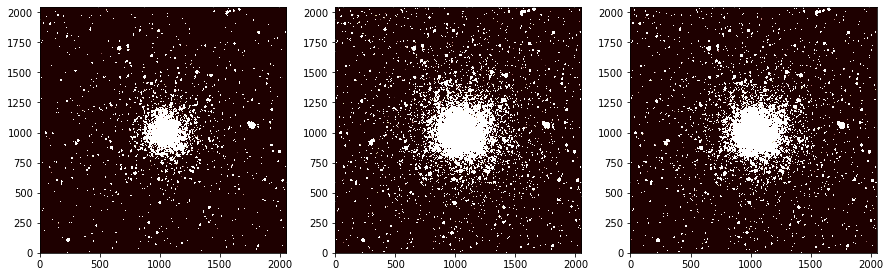

In [34]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(n_m56_g,vmin = np.percentile(bias_1, 5), vmax=np.percentile(bias_1, 90), origin='lower', interpolation='nearest',cmap='pink') 
plt.subplot(1,3,2)
plt.imshow(n_m56_i,vmin = np.percentile(bias_2, 5), vmax=np.percentile(bias_2, 90),
origin='lower', interpolation='nearest',cmap='pink') 
plt.subplot(1,3,3)
plt.imshow(n_m56_r,vmin = np.percentile(master_bias, 5), vmax=np.percentile(master_bias, 90),
origin='lower', interpolation='nearest',cmap='pink') ;

NOW BEGINS M102

In [36]:
m102_g = CCDData.read('m102/M102_g_60.0086.fits', unit = 'adu')
m102_halpha = CCDData.read('m102/M102_halpha_300.0085.fits', unit = 'adu')
m102_r_30 = CCDData.read('m102/M102_r_30.0082.fits', unit = 'adu')
m102_r_10 = CCDData.read('m102/M102_r_10.0083.fits', unit = 'adu')
m102_r_60 = CCDData.read('m102/M102_r_60.0084.fits', unit = 'adu')

In [37]:
m102_g_nb = overscan_be_gone(m102_g)
m102_halpha_nb = overscan_be_gone(m102_halpha)
m102_r_30_nb = overscan_be_gone(m102_r_30)
m102_r_10_nb = overscan_be_gone(m102_r_10)
m102_r_60_nb = overscan_be_gone(m102_r_60)

In [ ]:
m102_g_b = ccdp.subtract_bias(m102_g_nb, )
m102_halpha_b = ccdp.subtract_bias(m102_halpha_nb)
m102_r_b1 = ccdp.subtract_bias(m102_r_30_nb)
m102_r_b2 = ccdp.subtract_bias(m102_r_10_nb)
m102_r_b3 = ccdp.subtract_bias(m102_r_60_nb)